## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2025-03-13 22:25:27.739238: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 22:25:27.746706: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-13 22:25:27.756417: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-13 22:25:27.756431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 22:25:27.763396: I tensorflow/core/platform/cpu_feature_gua

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow tiene acceso a las siguientes GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("No se detectaron GPU disponibles para TensorFlow.")

TensorFlow tiene acceso a las siguientes GPU(s):
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2025-03-13 22:25:28.638097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-13 22:25:28.665924: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-13 22:25:28.665962: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Loading the data

In [3]:
# Load CSV
dataset = pd.read_csv('SP500.csv', index_col=0)
type(dataset)

pandas.core.frame.DataFrame

## Exploratory Data Analysis

In [4]:
# shape
dataset.shape

(2516, 6)

In [5]:
# show dataset head
dataset.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [6]:
# data statistics
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,1962.147905,1971.346574,1952.200450,1962.608854,1962.608854,3.715246e+09
std,589.031496,590.190988,587.623893,588.910251,588.910251,8.134033e+08
min,1027.650024,1032.949951,1010.909973,1022.580017,1022.580017,1.025000e+09
25%,1381.642548,1390.700012,1372.800018,1384.404999,1384.404999,3.237625e+09
50%,1985.319946,1993.084961,1975.660034,1986.479981,1986.479981,3.587920e+09
75%,2434.179931,2441.522522,2427.959961,2433.967529,2433.967529,4.076530e+09
max,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,1.061781e+10


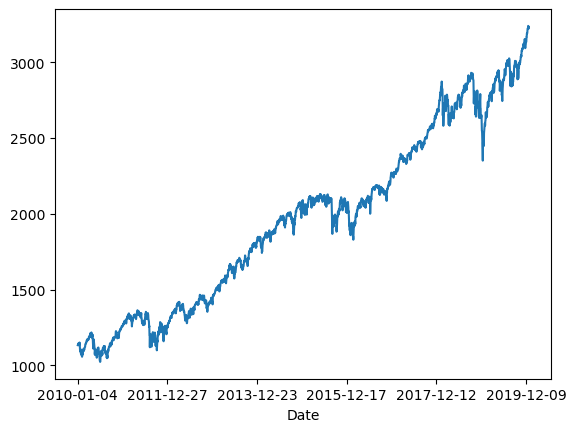

In [7]:
# plot close prices
dataset['Close'].plot()
plt.show()

## Data Preparation

In [8]:
# Data cleaning
if(dataset.isnull().values.any()):
   dataset = dataset.ffill()

## Evaluate Algorithms and models

In [9]:
# Train test split
validation_size = 0.2
X = list(dataset['Close'].astype('float'))
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0: train_size], X[train_size:len(X)]

In [10]:
# RL agent class
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size  # Tamaño del estado (ventana histórica)
        self.action_size = 3          # Acciones posibles: [vender, comprar, mantener]
        self.memory = deque(maxlen=1000)  # Memoria de experiencias (experience replay)
        self.inventory = []            # Registro de activos comprados
        self.model_name = model_name   # Nombre del modelo pre-entrenado (si existe)
        self.is_eval = is_eval         # Modo evaluación (no explora)
        self.gamma = 0.95              # Factor de descuento de recompensas futuras
        self.epsilon = 1.0             # Tasa de exploración inicial (epsilon-greedy)
        self.epsilon_min = 0.01        # Mínimo epsilon permitido
        self.epsilon_decay = 0.995     # Tasa de decaimiento de epsilon
        self.model = load_model(model_name) if is_eval else self._model() # Red principal
        # Target Network (solo en modo entrenamiento)
        if self.is_eval:
            self.target_model = self.model  # Usa la misma red en evaluación
        else:
            self.target_model = self._model()  # Red separada
            self.target_model.set_weights(self.model.get_weights())  # Copia inicial de pesos
            self.update_target_every = 100  # Actualizar cada 100 pasos de entrenamiento
            self.step_count = 0  # Contador de pasos

    # Deep Q-Learning model returns the q-value when given state as input
    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation='relu'))  # Capa entrada
        model.add(Dense(units=32, activation='relu'))  # Capa oculta 1
        model.add(Dense(units=8, activation='relu'))    # Capa oculta 2
        model.add(Dense(self.action_size, activation='linear'))  # Capa salida (Q-valores)
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
        return model
    
    def act(self, state):
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)  # Exploración: acción aleatoria
        options = self.model.predict(state, verbose=0)
        return np.argmax(options[0])  # Explotación: acción con mayor Q-valor
    
    def expReplay(self, batch_size):
        # 1. Obtener mini-batch (muestreo secuencial - idealmente debería ser aleatorio)
        if len(self.memory) < batch_size:
            return
        mini_batch = random.sample(self.memory, batch_size) 
        
        # 2. Procesamiento vectorizado
        states = []
        targets = []
        
        for state, action, reward, next_state, done in mini_batch:
            # Calcular target Q-value
            target = reward
            if not done:
                # Usar target_model para predicciones futuras (¡CORRECCIÓN CLAVE!)
                target += self.gamma * np.amax(self.target_model.predict(next_state, verbose=0)[0])
            
            # Obtener predicción actual
            target_f = self.model.predict(state, verbose=0)
            # Actualizar solo la acción tomada
            target_f[0][action] = target
            
            # Acumular datos para entrenamiento vectorizado
            states.append(state[0])  # Desempaquetar el batch de 1 muestra
            targets.append(target_f[0])
        
        # 3. Entrenamiento en lote (¡AHORA VECTORIZADO!)
        self.model.fit(
            np.array(states), 
            np.array(targets),
            batch_size=batch_size,
            epochs=1,
            verbose=0
        )
        
        # 4. Actualizaciones post-entrenamiento (¡CORREGIR INDENTACIÓN!)
        # Decaimiento de epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        # Actualización de target network
        self.step_count += len(mini_batch)
        if self.step_count % self.update_target_every == 0:
            self.target_model.set_weights(self.model.get_weights())

### Helper functions

In [11]:
def formatPrice(n):
    return ("-$" if n < 0 else "$") + f"{abs(n):.2f}"

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def getState(data, t, n):
    d = t - n + 1
    # pad with t0
    block = data[d:t + 1] if  d >= 0 else -d * [data[0]] + data[0:t + 1]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.reshape(res, (1, -1))

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15, 5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label='Buying signal', markevery=states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label='Selling signal', markevery=states_sell)
    plt.title(f'Total gains: {float(profit)}')
    plt.legend()
    plt.show()

### Training the data

2025-03-13 22:25:28.806401: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-13 22:25:28.806454: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-13 22:25:28.806469: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-13 22:25:28.877900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-13 22:25:28.877942: I external/local_xla/xla/stream_executor

Running episode 0 / 5


I0000 00:00:1741904729.415273  915845 service.cc:145] XLA service 0x7fc0f0004b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741904729.415309  915845 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 950, Compute Capability 5.2
2025-03-13 22:25:29.420009: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-13 22:25:29.437225: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1741904729.473432  915845 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


_______________________________________
Total Profit: $10673.87
________________________________________


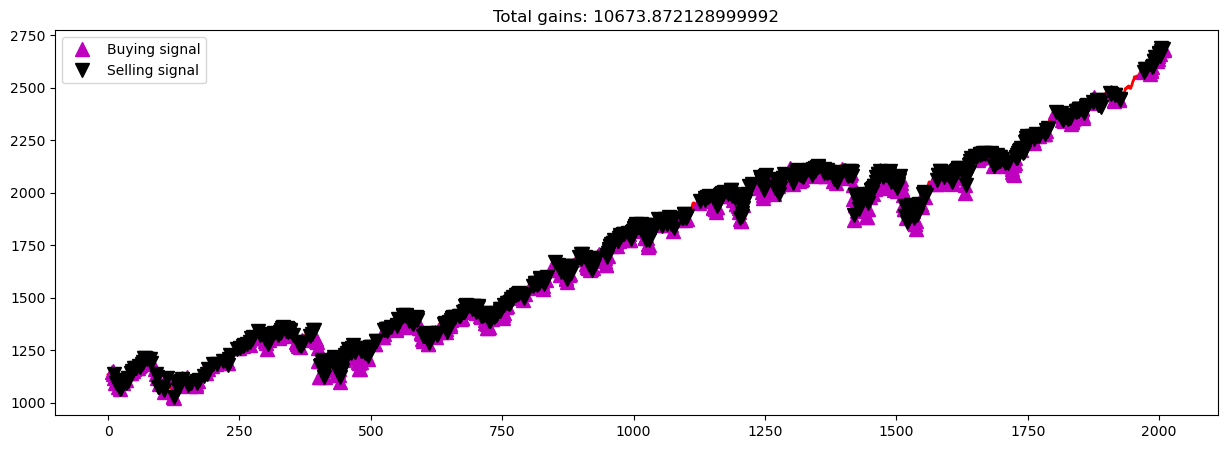

Running episode 1 / 5
_______________________________________
Total Profit: $38057.55
________________________________________


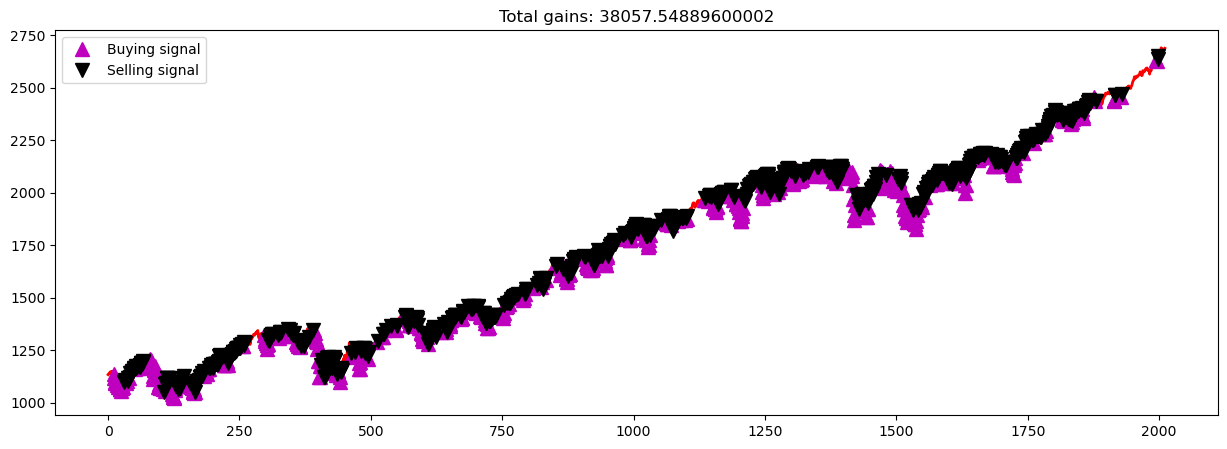

Running episode 2 / 5
_______________________________________
Total Profit: $18999.71
________________________________________


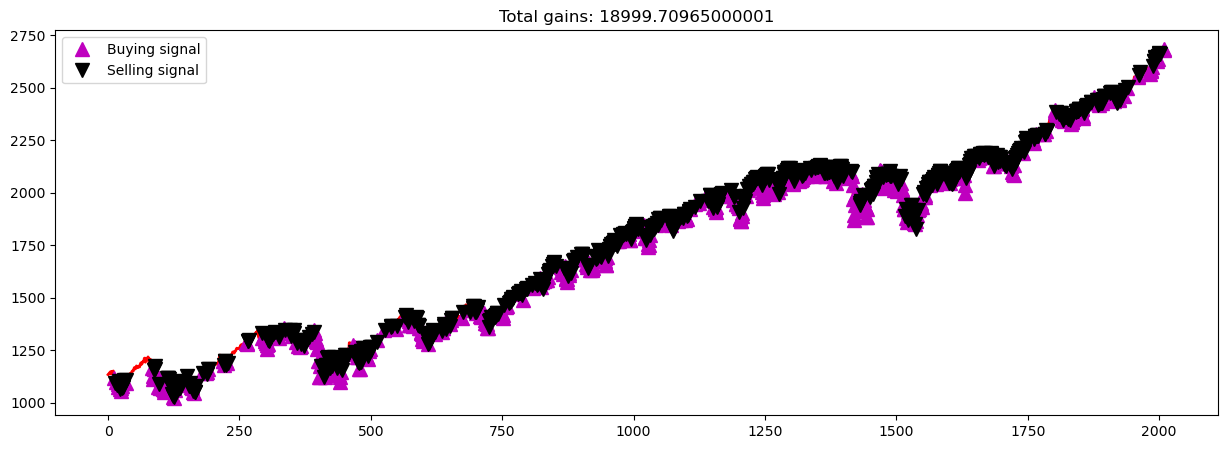

Running episode 3 / 5
_______________________________________
Total Profit: $27265.95
________________________________________


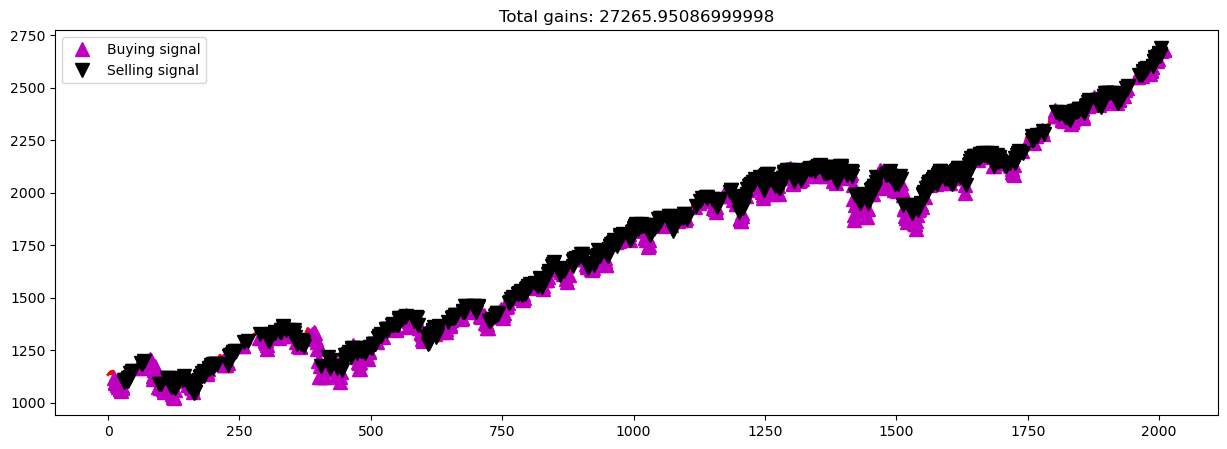

Running episode 4 / 5
_______________________________________
Total Profit: $56790.30
________________________________________


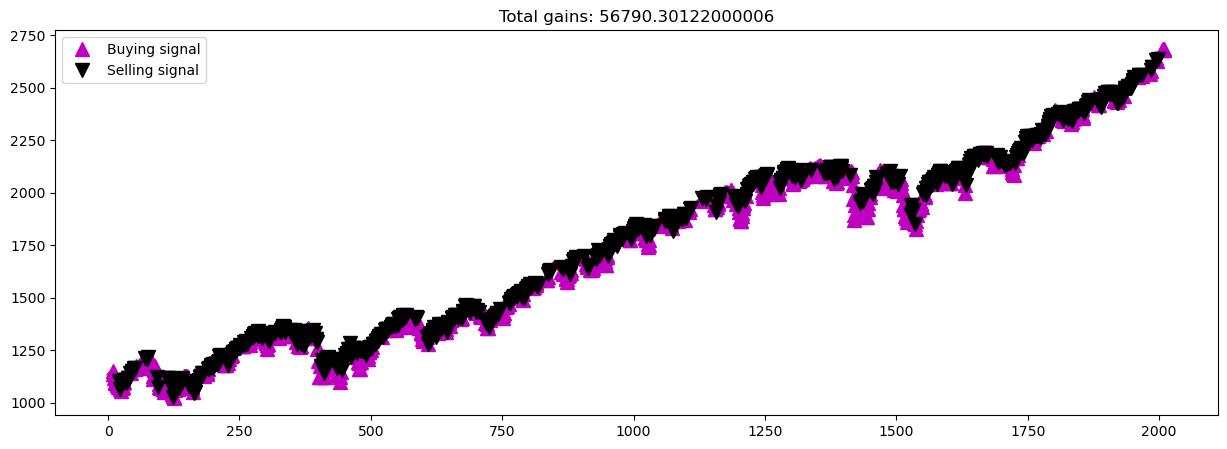

Running episode 5 / 5
_______________________________________
Total Profit: $30100.80
________________________________________


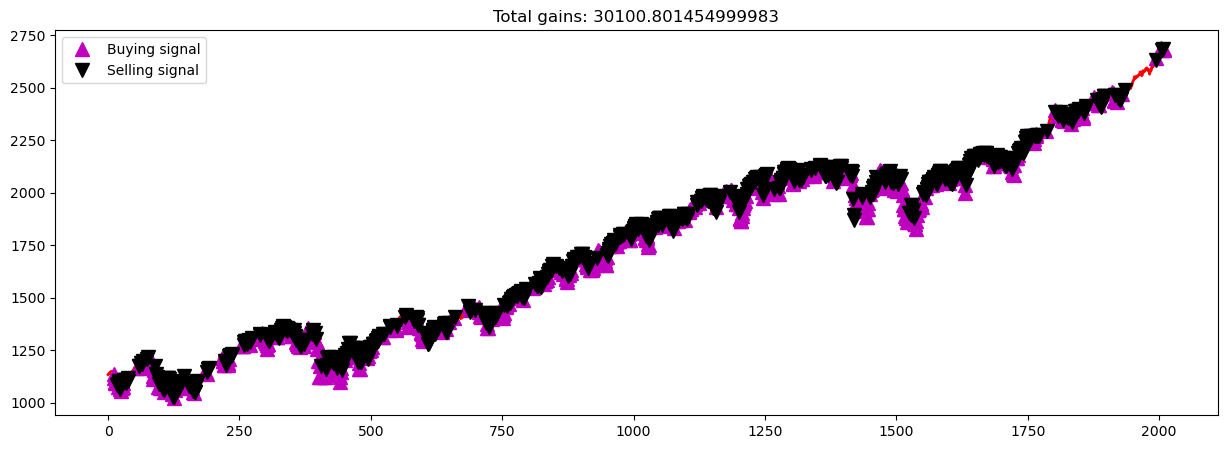

In [12]:
window_size = 15
agent = Agent(window_size)
# In this step we feed the closing value of the stock price
data = X_train
l = len(data) - 1
batch_size = 32
# An episode represents a complete pass over the data
episode_count = 5
# Training loop
for e in range(episode_count + 1):
    print(f"Running episode {e} / {episode_count}")
    state = getState(data, 0, window_size + 1)
    #set_trace()
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in range(l):
        action = agent.act(state)
        # hold
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0
        # buy
        if action == 1:
            agent.inventory.append(data[t])
            states_buy.append(t)
        # sell
        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            reward = data[t] - bought_price
            total_profit += data[t] - bought_price
            states_sell.append(t)
        done = True if t == l - 1 else False
        # Appends the details of the state action etc in the memory
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state
        if done:
            print("_______________________________________")
            print(f"Total Profit: {formatPrice(total_profit)}")
            print("________________________________________")
            # Chart to show how the model performs
            plot_behavior(data, states_buy, states_sell, total_profit)
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)

    if e % 2 == 0:
        agent.model.save(f"model_ep{e}.keras")

## Testing the Data

In [13]:
# Agent is already defined in the training set above
test_data = X_test
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
# Get the trained model
model_name = "model_ep" + str(episode_count - 1) + ".keras"
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []

Buy: $2798.03
Sell: $2810.30 | profit: $12.27
Buy: $2822.43
Sell: $2823.81 | profit: $1.38
Buy: $2821.98
Buy: $2762.13
Buy: $2648.94
Buy: $2695.14
Buy: $2681.66
Buy: $2581.00
Buy: $2619.55
Buy: $2656.00
Sell: $2662.94 | profit: -$159.04
Sell: $2698.63 | profit: -$63.50
Sell: $2731.20 | profit: $82.26
Sell: $2732.22 | profit: $37.08
Sell: $2716.26 | profit: $34.60
Sell: $2701.33 | profit: $120.33
Sell: $2703.96 | profit: $84.41
Sell: $2747.30 | profit: $91.30
Buy: $2744.28
Buy: $2713.83
Buy: $2677.67
Buy: $2691.25
Sell: $2720.94 | profit: -$23.34
Sell: $2728.12 | profit: $14.29
Sell: $2726.80 | profit: $49.13
Sell: $2738.97 | profit: $47.72
Buy: $2765.31
Buy: $2749.48
Buy: $2747.33
Buy: $2752.01
Buy: $2712.92
Buy: $2716.94
Buy: $2711.93
Buy: $2643.69
Buy: $2588.26
Buy: $2658.55
Buy: $2612.62
Buy: $2605.00
Buy: $2640.87
Buy: $2581.88
Sell: $2614.45 | profit: -$150.86
Sell: $2644.69 | profit: -$104.79
Sell: $2662.84 | profit: -$84.49
Sell: $2604.47 | profit: -$147.54
Buy: $2613.16
Sell: $

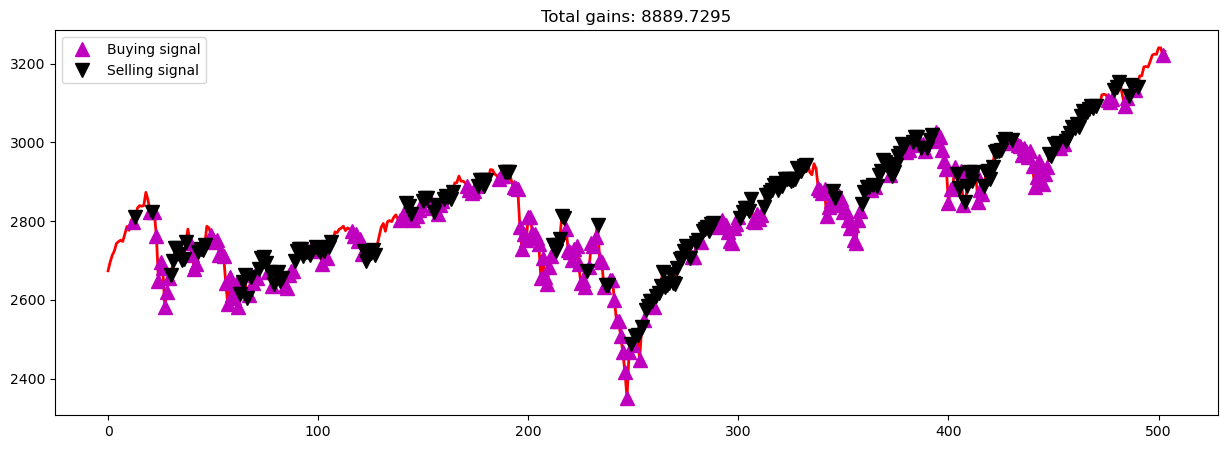

In [14]:
for t in range(l_test):
    action = agent.act(state)
    # print(action)
    # set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data[t])
        states_buy_test.append(t)
        print("Buy: " + formatPrice(test_data[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("---------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("---------------------------------------------")

plot_behavior(test_data, states_buy_test, states_sell_test, total_profit)